## *UF Audio Engineering Society

Jackson Cornell, Justin Broce, Eric Barkuloo


# **Creating an instrument classifier**



In [2]:
#@title Loading libraries
!pip install tensorflow-io
import librosa
import os
import numpy as np
import matplotlib.pyplot as plt
import librosa.display
import IPython
import soundfile as sf
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, Input
import tensorflow_io as tfio
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay



     |████████████████████████████████| 23.4 MB 2.3 MB/s 


In [3]:
#@title Loading Data
!git clone https://github.com/aesuf/orchestral_samples;


Cloning into 'orchestral_samples'...
remote: Enumerating objects: 11633, done.
remote: Counting objects: 100% (2/2), done.
remote: Total 11633 (delta 1), reused 1 (delta 1), pack-reused 11631
Receiving objects: 100% (11633/11633), 1.28 GiB | 11.95 MiB/s, done.
Resolving deltas: 100% (31/31), done.
Checking out files: 100% (11319/11319), done.


In [4]:
#@title helper functions

#We take the first n seconds of the audio. If the audio is too short, we append zeros.

def trim_sample(y,sr,seconds):
  return librosa.util.fix_length(y,size=int((sr*seconds)))


def get_filenames():
  #files is a list of the names of all of our downloaded files
  files = os.listdir('orchestral_samples/data')
  """
  files[0] might look like 'bass-clarinet_Fs3_15_pianissimo_normal.wav'
  so we append 'orchestral_samples/data' to the start of every file
  so we can load it easier
  """
  return list(
      map(
      lambda file: 'orchestral_samples/data/' + file , files)
  )
  #scaling spectrograms as normalized images:
  #hopefully this will fix things, idk
def scale_minmax(X, min=0.0, max=1.0):
    X_std = (X - X.min()) / (X.max() - X.min())
    X_scaled = X_std * (max - min) + min
    return X_scaled

In [5]:
#@title helper functions
def get_instruments():
  instruments = {
  "bass-clarinet": 0,
  "contrabassoon": 1,
  "cello": 2,
  "clarinet": 3,
  "bassoon": 4,
  "double-bass": 5,
  "french-horn": 6,
  "guitar": 7,
  "mandolin": 8,
  "oboe": 9,
  "saxophone": 10,
  "trombone": 11,
  "trumpet": 12,
  "tuba": 13,
  "viola": 14,
  "violin": 15,
  
   #instruments is a python dictionary
  #read more at https://www.w3schools.com/python/python_dictionaries.asp
  #similiar to a hashmap, or c++'s ordered_map
}
  return instruments


"""
This function will return the instrument class value given the filename ie
get_y_val('cello_Gs2_05_pianissimo_arco-normal.wav')
  returns 2

And get_y_val(double-bass_D2_1_pianissimo_arco-normal.wav)
returns 5

"""
def get_y_value(file):
  instruments = get_instruments()
  for instrument in instruments:
    #string.find(foo) returns the first occurence of foo,
    # and -1 if foo is not in the string.
    if file.find(instrument)!=-1:
      return instruments[instrument]
  return "NULL"

def get_y_values():
  #loading the names of the files in /data to a list
  files = os.listdir('orchestral_samples/data')
  """
  map(f,iterable) will apply functiion f to each element in iterable container.
  In this case we are applying the function get_y_value, 
  to every element in files. List will turn a map object into a list,
   and then we can turn the list into a numpy array
  """
  return np.array(
      list(
          map(get_y_value,files)
          )
      )
  
"""
 generates numpy array that maps indices to instruments
 ie get_labels()[3] returns 'clarinet'
"""
def get_labels():
  inv_map = {v: k for k, v in get_instruments().items()}
  return np.array(list(inv_map.items()))[:,[1]]


##loading the names of all of our files from our downloaded data
Our dataset contains 11318 samples, of 16 different instrument types.
Each sample will have a note name and a technique of playing, in the filename.

In [6]:
files = get_filenames()
print('number of samples: ', len(files))



number of samples:  11318


We can visualize our samples and take a listen to a couple different sounds.

example file name:  orchestral_samples/data/bass-clarinet_D2_025_pianissimo_normal.wav


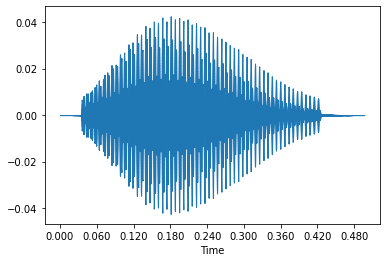

In [7]:
i = np.random.randint(0,len(files)-1)
librosa.display.waveshow(*librosa.load(files[i]))

print('example file name: ', files[i])

In [8]:

IPython.display.Audio(files[i]) 

#Using TensorFlow for loading in data:

In [27]:
#@title Default title text
AUTOTUNE = tf.data.experimental.AUTOTUNE
def spectrogram(y):
  nfft=512
  window=512
  stride=256
  s = tfio.audio.spectrogram(y, nfft=nfft, window=window, stride=stride)
  s = tfio.audio.melscale(s, rate=22050, mels=128, fmin=0, fmax=11025)
  return tfio.audio.dbscale(s,top_db=80)   
def load_wav_22k_mono(filename):
    """ Load a WAV file, convert it to a float tensor, resample to 22 kHz single-channel audio. """
    file_contents = tf.io.read_file(filename)
    wav, sample_rate = tf.audio.decode_wav(
          file_contents,
          desired_samples=66000,
          desired_channels=1)
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=22050)
    return wav
def process_feature(file_name):
  return spectrogram(load_wav_22k_mono(file_name))
dataset = (tf.data.Dataset.from_tensor_slices(get_filenames())
          .map(process_feature, num_parallel_calls=AUTOTUNE))
x = np.array([d.numpy() for d in dataset])


In [32]:
x.shape

(11318, 129, 128)

Function to extract mel melspectrogram from a sample

# **Test Train Split etc:** 

*finally we will have data in a format that can be fed into models*


In [41]:
#@title importing more stuff
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.utils import to_categorical # it's red but okay

##Performing test/train split:

In [42]:
X_train, X_test, y_train, y_test = train_test_split(
    x, get_y_values(), test_size=0.33, random_state=42)

X train and test are the spectrograms

Y train and test are the what instruments the samples are

In [46]:
print(f"""
X_train dims: {X_train.shape}
X_test dims: {X_test.shape}
Y_train dims: {y_train.shape}
Y_test dims: {y_test.shape}
"""
)
labels=get_labels()


X_train dims: (7583, 129, 128)
X_test dims: (3735, 129, 128)
Y_train dims: (7583,)
Y_test dims: (3735,)



In [47]:
y_train_cat = keras.utils.to_categorical(y_train)
y_test_cat = keras.utils.to_categorical(y_test)

If you want to know what instrument a sample is by y_value:

In [48]:
print(y_train_cat.shape)
print(labels[np.argmax(y_train_cat)])
print(y_train.shape)
print(labels[y_train[0]])

(7583, 16)
['tuba']
(7583,)
['tuba']


#CNN

In [67]:
norm_layer = layers.Normalization()
norm_layer.adapt(X_train)


In [91]:
#https://www.tensorflow.org/tutorials/audio/simple_audio
model = Sequential([
    layers.Input(shape=(129, 128,1)),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(16, activation='softmax', use_bias=False),
])

model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_5 (Resizing)       (None, 32, 32, 1)         0         
                                                                 
 normalization_2 (Normalizat  (None, 32, 32, 128)      257       
 ion)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 30, 30, 32)        36896     
                                                                 
 conv2d_11 (Conv2D)          (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 dropout_22 (Dropout)        (None, 14, 14, 64)       

In [92]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [93]:
h = model.fit(X_train, y_train, epochs = 16, validation_data = (X_test, y_test))

Epoch 1/16


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


237/237 [==============================] - 3s 9ms/step - loss: 1.7122 - accuracy: 0.4724 - val_loss: 0.5465 - val_accuracy: 0.8479
Epoch 2/16
237/237 [==============================] - 2s 7ms/step - loss: 0.6938 - accuracy: 0.7827 - val_loss: 0.3134 - val_accuracy: 0.9173
Epoch 3/16
237/237 [==============================] - 2s 8ms/step - loss: 0.4672 - accuracy: 0.8530 - val_loss: 0.2664 - val_accuracy: 0.9242
Epoch 4/16
237/237 [==============================] - 2s 7ms/step - loss: 0.3539 - accuracy: 0.8891 - val_loss: 0.2103 - val_accuracy: 0.9363
Epoch 5/16
237/237 [==============================] - 2s 6ms/step - loss: 0.2906 - accuracy: 0.9073 - val_loss: 0.1700 - val_accuracy: 0.9486
Epoch 6/16
237/237 [==============================] - 1s 6ms/step - loss: 0.2442 - accuracy: 0.9221 - val_loss: 0.1444 - val_accuracy: 0.9606
Epoch 7/16
237/237 [==============================] - 1s 6ms/step - loss: 0.2211 - accuracy: 0.9280 - val_loss: 0.1604 - val_accuracy: 0.9558
Epoch 8/16
237/23

In [99]:
y_pred = np.argmax(model.predict(X_test),axis = 1)

In [102]:
cm = confusion_matrix(y_test, y_pred)

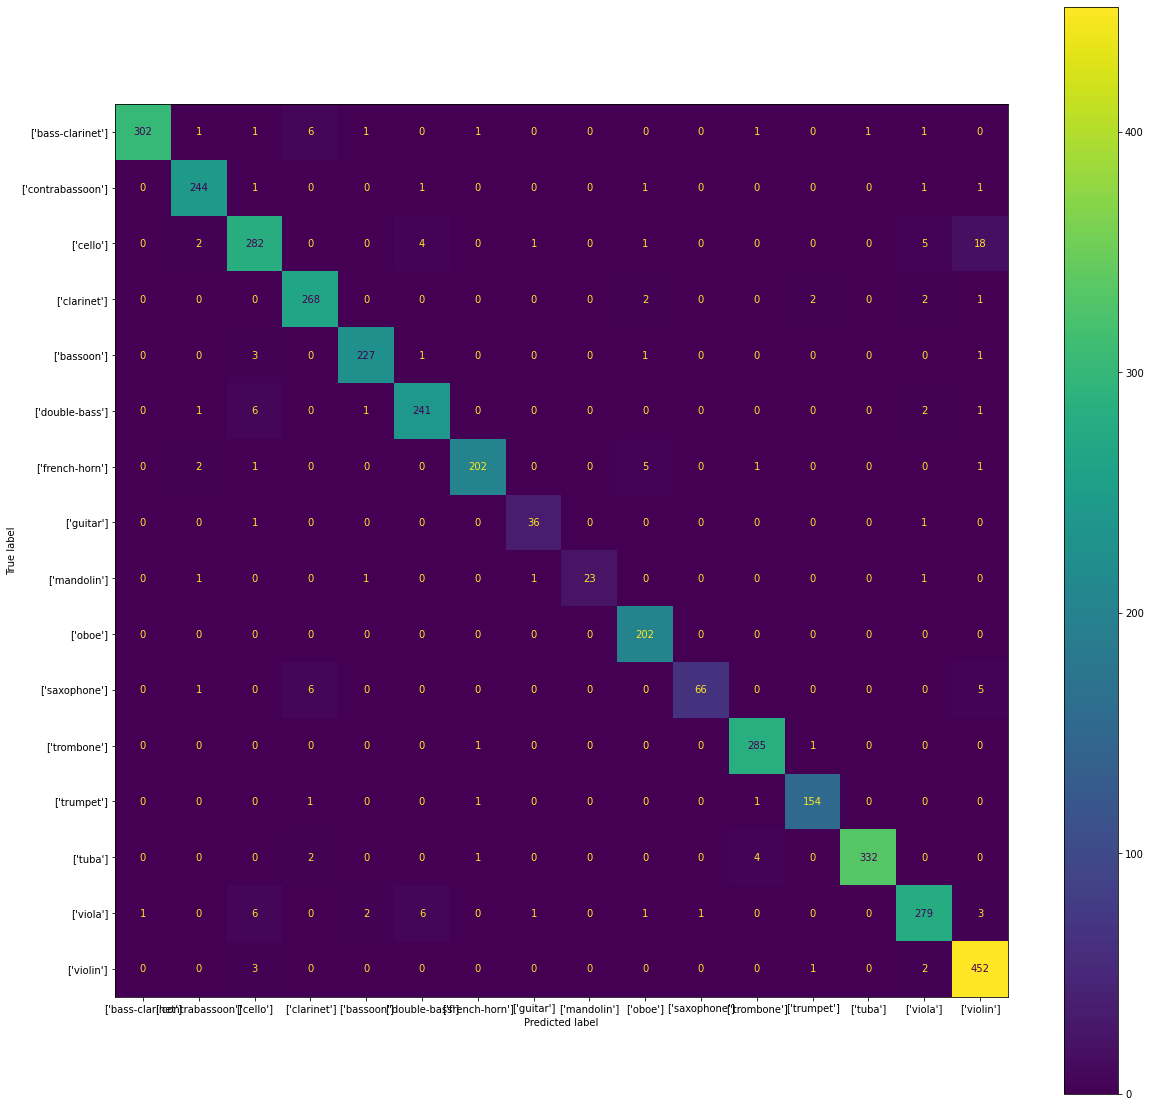

In [114]:
disp = ConfusionMatrixDisplay(cm,display_labels=labels)
fig, ax = plt.subplots(figsize=(20, 20))
disp.plot(ax=ax)
plt.show()